# **Advanced Techniques in Data Analysis - MACHINE LEARNING PROJECT** 

## Objectives and Motivation

In this project we want to make a deep dive into the world of stock prediction, more specifically on the PayPal stock. Our objectives are:

- Make a rigorous time series analysis 

- Make a classifier to evaluate if the stock will go up or down

- Risk management

# Importing the Paypal Stock information

## Imports and Data Cleaning

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import sklearn.svm as svc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

Now we download the Standard & Poor 500 dataset (or keep it updated)

In [378]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yash16jr/s-and-p500-daily-update-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/300


In [379]:

import os

path = "/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275"

print(os.listdir(path))

['SnP_daily_update.csv']


In [380]:

df = pd.read_csv(
    
    '/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275/SnP_daily_update.csv',
    
    header=[0, 1],         
    index_col=0,          
    parse_dates=True      
)

print(df.head())


Price           Close                                                      \
Ticker              A      AAPL ABBV ABNB        ABT      ACGL        ACN   
Date                                                                        
2010-01-04  19.891678  6.424604  NaN  NaN  18.414782  7.601905  31.492178   
2010-01-05  19.675604  6.435713  NaN  NaN  18.266010  7.576549  31.686796   
2010-01-06  19.605700  6.333346  NaN  NaN  18.367451  7.543795  32.023655   
2010-01-07  19.580280  6.321635  NaN  NaN  18.519613  7.499420  31.993717   
2010-01-08  19.573919  6.363664  NaN  NaN  18.614286  7.484628  31.866457   

Price                                        ...   Volume                    \
Ticker           ADBE        ADI        ADM  ...       WY     WYNN      XEL   
Date                                         ...                              
2010-01-04  37.090000  21.975159  20.614487  ...  1832400  4741400  2670400   
2010-01-05  37.700001  21.940468  20.725853  ...  1724500  5644300 

In [381]:
df_pypl_completo = df.xs('PYPL', level=1, axis=1)

In [382]:
df_pypl_completo.columns = [col.lower() for col in df_pypl_completo.columns]

if 'price' in df_pypl_completo.columns:
    df_pypl_completo = df_pypl_completo.drop(columns=['price'])

df_pypl_completo.dropna(subset=['close'], inplace=True)

df_pypl = df_pypl_completo.copy()

print("PayPal's DataFrame (PYPL) Clean and Ready:")
print(df_pypl.head())
print(f"Column number: {df_pypl.shape[1]}")
print(f"Existent Columns: {list(df_pypl.columns)}")


PayPal's DataFrame (PYPL) Clean and Ready:
                close       high        low       open     volume
Date                                                             
2015-07-06  36.709999  39.750000  36.000000  38.000000  5866600.0
2015-07-07  36.619999  37.810001  36.000000  37.720001  7359000.0
2015-07-08  34.700001  36.360001  34.529999  36.340000  5387700.0
2015-07-09  34.500000  35.520000  33.990002  35.099998  3760100.0
2015-07-10  34.689999  35.189999  33.980000  34.660000  4472800.0
Column number: 5
Existent Columns: ['close', 'high', 'low', 'open', 'volume']


# Time Series Analysis


Stock market predicition must be preceded by a rigorous Time Series Analysis. Financial data is unique because observations are not independent and identifcally distributed, they exibit autocorrelation and non-stationarity.


Time Series Analysis serves two critical functions:

- Risk Management: Quantifying extreme events. This will provide context for interpreting machine learning models.

- Validation and feature engineering: It allow us to confirm the statistical properties of data (Stationarity and other)

## Discrete Analysis

### Logarithmic Return 

### Histogram of returns

#### Testing for Normality

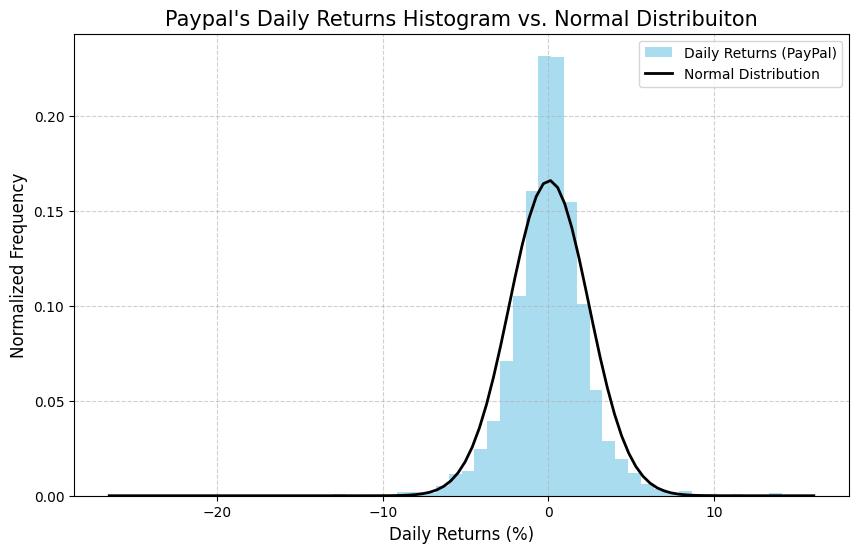

In [383]:
ret = 100 * (df_pypl['close'].pct_change())
plt.figure(figsize=(10,6))
plt.hist(ret, bins=50, density = True, label = "Daily Returns (PayPal)", color = "skyblue", alpha=0.7)

from scipy.stats import norm

mu, sigma = ret.mean(), ret.std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma) 


plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

title = "Paypal's Daily Returns Histogram vs. Normal Distribuiton"
plt.title(title, fontsize=15)
plt.xlabel("Daily Returns (%)", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [384]:
from scipy.stats import shapiro

ret_clean = ret.dropna() 

shapiro_result = shapiro(ret_clean)

alpha = 0.05

print(f"Shapiro-Wilk Statistics: {shapiro_result[0]:.4f}")
print(f"P-value: {shapiro_result[1]:.4f}")

# Test Null Hypothesis
if shapiro_result[1] <= alpha:
    print("Conclusion: Null hypothesis of the Shapiro-Wilk test (the population is normally distributed) is rejected.")
else:
    print("Conclusion: The null hypothesis of the Shapiro-Wilk test can't be rejected.")

Shapiro-Wilk Statistics: 0.9281
P-value: 0.0000
Conclusion: Null hypothesis of the Shapiro-Wilk test (the population is normally distributed) is rejected.


Like most statistical significance tests, if the sample size is sufficiently large this test may detect even trivial departures from the null hypothesis (i.e., although there may be some statistically significant effect, it may be too small to be of any practical significance); thus, additional investigation of the effect size is typically advisable, e.g., a Q–Q plot in this case.

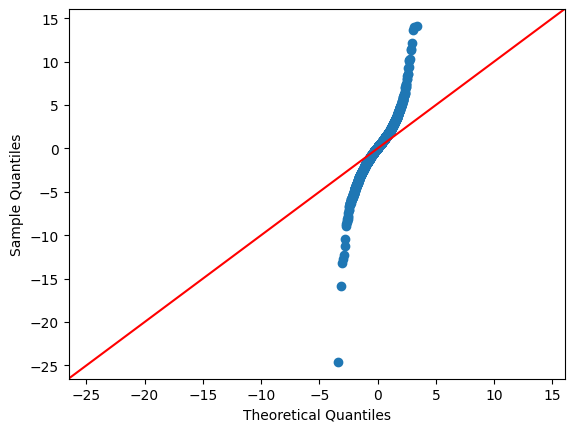

In [385]:
#Create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(ret_clean, line='45')

plt.show()

If the points on the plot fall roughly along a straight diagonal line, then we typically assume a dataset is normally distributed. However, the points on this plot clearly don’t fall along the red line, so we would not assume that this dataset is normally distributed.

#### Skewness and Kurtosis Evaluation

Since it's proven that this dataset is not normally distributed (being a $t$-student distribution), we should evaluate the skewness and the kurtosis. 

In [386]:
from scipy.stats import skew, kurtosis

kurtosis_value = kurtosis(ret_clean, fisher=False) 

skewness_value = skew(ret_clean)

print(f"Skewness: {skewness_value:.4f}")
print(f"Kurtosis: {kurtosis_value:.4f}")

Skewness: -0.3848
Kurtosis: 11.6415


The analysis of PayPal stock returns shows negative skewness, indicating that the left tail of the distribution is longer and extreme negative returns occur more frequently than extreme positive ones. Additionally, the very high kurtosis points to the presence of many extreme values overall.

In combination, negative skewness and high kurtosis suggest that the returns are prone to significant downside risk: while extreme events can occur on both sides, a substantial portion is likely to be large losses. This indicates that traditional risk models assuming normality may underestimate the probability and magnitude of extreme losses, justifying the use of advanced risk models capable of capturing fat tails and asymmetry in financial returns, such as GARCH using $t$-distributions.

## Stationary Test

## Time Dependency Analysis

# PayPal Stock Prediction using a Support Vector Machine 


The idea of Support Vector Machine is by finding a hyperplane to divide the data into groups, this will classify if the stock is going up or down based on historic data.

This only shows history up to 2015-07-06 because PayPal only turned public in July of 2015 (The S&P500 file starts at 2010)

Since the Support Vector Machine is a classifier we need to define the target

- 1 if tomorrow's price is BIGGER than today
- 0 if tomorrow's price is SMALLER than today

In [387]:
df_pypl["Target"]= np.where(df_pypl["close"].shift(-1) > df_pypl["close"], 1, 0)

In [388]:
df_ml_final = df_pypl.dropna()

In [389]:
features = ["open", "high", "low", "close", "volume"]
X = df_ml_final [features]
y = df_ml_final["Target"]

In [390]:
print( "DataFrame da Paypal com features e Target")
print(df_ml_final[features + ["Target"]].tail())
print(f"\nNúmero de amostras prontas para o SVM (X e y): {X.shape[0]}")
print(f"Número de Features (X): {X.shape[1]}")

DataFrame da Paypal com features e Target
                 open       high        low      close      volume  Target
Date                                                                      
2025-10-13  70.720001  70.930000  68.162003  68.860001  20036800.0       1
2025-10-14  67.410004  69.709999  66.769997  69.150002  12968500.0       0
2025-10-15  69.385002  69.875000  67.839996  67.980003  11247300.0       0
2025-10-16  68.129997  68.599998  65.419998  66.050003  19258500.0       1
2025-10-17  65.535004  67.709999  65.449997  67.410004  11141800.0       0

Número de amostras prontas para o SVM (X e y): 2589
Número de Features (X): 5


In [391]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)

In [392]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [393]:
model = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42, class_weight='balanced')

In [394]:
model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=42)

In [395]:
y_pred = model.predict(X_test_scaled)

In [396]:
print(accuracy_score(y_test, y_pred))

0.5328185328185329


In [397]:
cm= confusion_matrix(y_test, y_pred)
print(cm)

[[138 104]
 [138 138]]


In [398]:
print(classification_report(y_test, y_pred, target_names=['DOWN (0)', 'UP (1)']))

              precision    recall  f1-score   support

    DOWN (0)       0.50      0.57      0.53       242
      UP (1)       0.57      0.50      0.53       276

    accuracy                           0.53       518
   macro avg       0.54      0.54      0.53       518
weighted avg       0.54      0.53      0.53       518



As we can see, using only the features provided by the dataset, we got a result of 53%, which is a slight improvement to choosing randomly. But for some strange reason, the model can predict more UPs then DOWNs

## Moving Average

Our solution to improve the model is to use feature engineering. Our objective is to add features with low correlations between the already added ones to get useful information into the model. First we will calculate some simple moving averages (SMA):

$$SMA = \frac{1}{n} \sum_{i=1}^{n} P_i$$

We decided to use $n=20$, $n=50$, $n=100$ and $n=200$.

In [399]:
periods = [20, 50, 100, 200]

for n in periods:
    
    df_pypl[f'SMA_{n}'] = df_pypl['close'].rolling(window=n).mean()


df_pypl.dropna(inplace=True)

# Verificação das novas features
print("DataFrame da PayPal após adicionar SMAs:")
print(df_pypl.tail())
print(f"Número de Features (X) agora: {df_pypl.shape[1]}")

DataFrame da PayPal após adicionar SMAs:
                close       high        low       open      volume  Target  \
Date                                                                         
2025-10-13  68.860001  70.930000  68.162003  70.720001  20036800.0       1   
2025-10-14  69.150002  69.709999  66.769997  67.410004  12968500.0       0   
2025-10-15  67.980003  69.875000  67.839996  69.385002  11247300.0       0   
2025-10-16  66.050003  68.599998  65.419998  68.129997  19258500.0       1   
2025-10-17  67.410004  67.709999  65.449997  65.535004  11141800.0       0   

             SMA_20   SMA_50  SMA_100   SMA_200  
Date                                             
2025-10-13  69.3580  68.8970  71.0046  72.52975  
2025-10-14  69.4730  68.9198  70.9796  72.43425  
2025-10-15  69.4410  68.9228  70.9449  72.33345  
2025-10-16  69.3175  68.8554  70.9069  72.22940  
2025-10-17  69.2770  68.8392  70.8662  72.13930  
Número de Features (X) agora: 10


In [400]:
features_SMA = ["open", "high", "low", "close", "volume",  "SMA_20", "SMA_50", "SMA_100", "SMA_200"]
X_SMA = df_pypl [features_SMA]
y = df_pypl["Target"]

In [401]:
X_train_SMA, X_test_SMA, y_train_SMA, y_test_SMA = train_test_split( X_SMA, y, test_size=0.2, shuffle=False)

In [402]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled_SMA= scaler.fit_transform(X_train_SMA)
X_test_scaled_SMA = scaler.transform(X_test_SMA)

model_SMA = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42,class_weight='balanced')
model_SMA.fit(X_train_scaled_SMA, y_train_SMA)
y_pred_SMA = model_SMA.predict(X_test_scaled_SMA)
print(accuracy_score(y_test_SMA, y_pred_SMA))
cm_SMA= confusion_matrix(y_test_SMA, y_pred_SMA)
print(cm_SMA)
print(classification_report(y_test_SMA, y_pred_SMA, target_names=['DOWN (0)', 'UP (1)']))


0.5376569037656904
[[114 110]
 [111 143]]
              precision    recall  f1-score   support

    DOWN (0)       0.51      0.51      0.51       224
      UP (1)       0.57      0.56      0.56       254

    accuracy                           0.54       478
   macro avg       0.54      0.54      0.54       478
weighted avg       0.54      0.54      0.54       478



As we can see we got a slight improvement from using the moving averages, but if we see the correlation matrix, SMA's and the already added features are higly correlated

Correlação das Features com o Target (Lagged e Limpo):

Target     1.000000
low       -0.010985
open      -0.011734
close     -0.012427
high      -0.012661
SMA_20    -0.013409
SMA_50    -0.016857
SMA_100   -0.026301
SMA_200   -0.040358
volume    -0.066811
Name: Target, dtype: float64
--------------------------------------------------


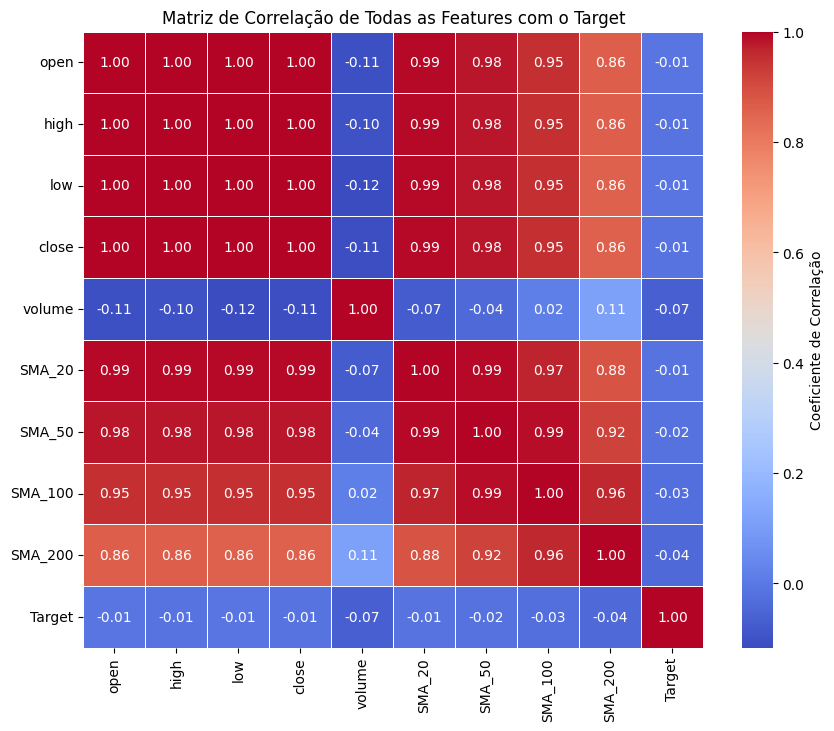

In [403]:
correlation_df = pd.concat([X_SMA, y], axis=1)

# 2. Calcular a matriz de correlação
correlation_matrix = correlation_df.corr()

# 3. Mostrar a correlação das features APENAS com a coluna 'Target' (ordenada)
print("Correlação das Features com o Target (Lagged e Limpo):\n")
print(correlation_matrix.loc['Target'].sort_values(ascending=False))
print("-" * 50)

# 4. Visualização da matriz de correlação (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Mostrar os valores de correlação
    cmap='coolwarm',     # Esquema de cores (coolwarm: quente para positivo, frio para negativo)
    fmt=".2f",           # Formato para 2 casas decimais
    linewidths=.5,       # Linhas entre as células
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('Matriz de Correlação de Todas as Features com o Target')

plt.show()

Volume and target are the only features without correlation, this is due to the definition of the other features, which is essentially **price**. We will proceed to a PCA.

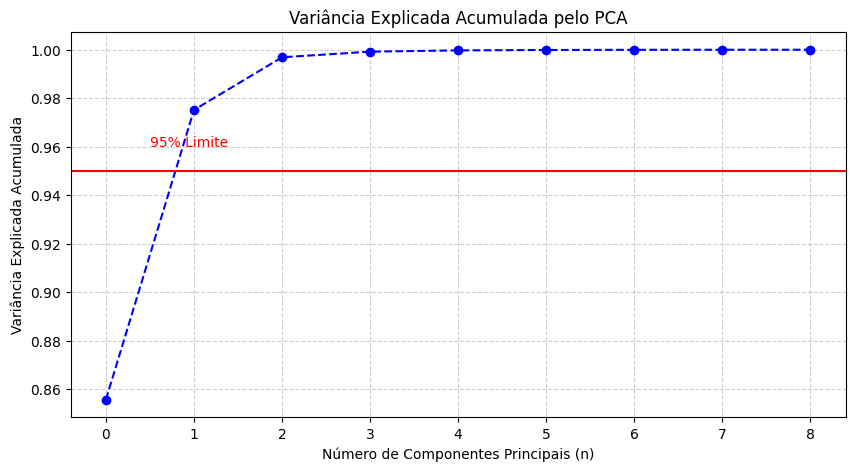

Variância explicada por cada Componente Principal:
PC 1: 0.8557
PC 2: 0.1195
PC 3: 0.0217
PC 4: 0.0023
PC 5: 0.0005
PC 6: 0.0002
PC 7: 0.0001
PC 8: 0.0000
PC 9: 0.0000


In [404]:
from sklearn.decomposition import PCA

# --- PASSO 1: Escolher o número de componentes ---
# Começamos com o número total de features (9) para analisar a variância.
pca = PCA(n_components=None)
pca.fit(X_train_scaled_SMA)

# --- PASSO 2: Análise da Variância Explicada ---
# O objetivo é ver quantos componentes (PCs) explicam a maior parte da variância (ex: 90% ou 95%)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='blue')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.xlabel('Número de Componentes Principais (n)')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True, linestyle='--', alpha=0.6)

# Linha de referência (ex: 95% da variância)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, '95% Limite', color = 'red', fontsize=10)


plt.show()

# Imprimir a variância explicada para cada PC
print("Variância explicada por cada Componente Principal:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC {i+1}: {ratio:.4f}")

# --- PASSO 3: Aplicação Final do PCA (Escolha n_components) ---
# Com base no gráfico, escolha n_components. Por exemplo, se 2 PCs explicarem 95%:
# n_pca_components = 2 
# pca_final = PCA(n_components=n_pca_components)
# X_train_pca = pca_final.fit_transform(X_train_scaled_SMA)
# X_test_pca = pca_final.transform(X_test_scaled_SMA)

# print(f"\nNúmero de features após PCA: {n_pca_components}")
# print("Formato de X_train_pca:", X_train_pca.shape)

In [452]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# --- 0. PREPARAÇÃO DOS DADOS ORIGINAIS COMPLETOS ---

# Garantir que temos X_SMA (features originais defasadas) e y_SMA (Target)
# Assumimos que X_SMA já foi criado, com shift(1) aplicado e NaNs removidos.
# Usaremos a DataFrame completa X_SMA (sem o split de treino/teste)

# X_FULL é o DataFrame de todas as 9 features (Preços/SMAs/Volume)
X_FULL = X_SMA.copy() 
y_FULL = y.copy()

# 1. ESCALAMENTO DE TODOS OS DADOS (para aplicar o PCA)
# Aplicamos o StandardScaler a todo o conjunto de features defasadas
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_FULL)

# --- 2. PCA APENAS NAS FEATURES CORRELACIONADAS (n=2) ---

# Colunas para PCA (preços e SMAs) - Índices 0, 1, 2, 3, 5, 6, 7, 8
pca_indices = [0, 1, 2, 3, 5, 6, 7, 8]
volume_index = 4
n_pca_components = 2

# Separar os dados escalados para PCA
X_full_pca_data = X_full_scaled[:, pca_indices]

# Aplicar o PCA (usamos o fit_transform em todos os dados)
pca_final = PCA(n_components=n_pca_components, random_state=42)
X_full_pca = pca_final.fit_transform(X_full_pca_data)


# --- 3. CRIAÇÃO DO DATAFRAME FINAL OTIMIZADO ---

# 3.1. Extrair a feature 'volume' escalada
volume_full_scaled = X_full_scaled[:, volume_index].reshape(-1, 1)

# 3.2. Combinação das 2 PCs com o volume escalado e o Target
# X_full_pca já é um array numpy com 2 colunas (PC1, PC2)
data_pca_combined = np.hstack((X_full_pca, volume_full_scaled))

# 3.3. Criação do novo DataFrame (df_pypl_PCA)
df_pypl_PCA = pd.DataFrame(
    data_pca_combined,
    columns=['PC1', 'PC2', 'Scaled_Volume'],
    index=X_FULL.index # Mantém o índice de data original
)

# Adicionar a variável Target
df_pypl_PCA['Target'] = y_FULL.values

# --- 4. VERIFICAÇÃO ---
print("DataFrame Otimizado df_pypl_PCA (Head):")
print(df_pypl_PCA.head())
print(f"\nNúmero total de amostras em df_pypl_PCA: {df_pypl_PCA.shape[0]}")

DataFrame Otimizado df_pypl_PCA (Head):
                 PC1       PC2  Scaled_Volume  Target
Date                                                 
2016-04-19 -2.849233 -0.141731      -0.687987       1
2016-04-20 -2.844613 -0.143762      -0.429485       1
2016-04-21 -2.831634 -0.151451      -0.741812       1
2016-04-22 -2.832892 -0.148749      -0.613898       0
2016-04-25 -2.830820 -0.148534      -0.399355       0

Número total de amostras em df_pypl_PCA: 2390


## RSI

In [453]:
def calculate_rsi(df, window=14):
    # 1. Calcular as variações diárias (returns)
    delta = df['close'].diff()

    # 2. Separar Ganhos (Gains) e Perdas (Losses)
    # Ganhos são delta > 0. Perdas são delta < 0 (em valores absolutos).
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # 3. Calcular a Média Móvel Exponencial (EMA) dos Ganhos e Perdas
    # O EMA é preferível ao SMA para o cálculo do RSI para suavizar melhor os dados.
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # 4. Calcular a Força Relativa (RS)
    # Adicionar uma pequena constante para evitar divisão por zero
    rs = avg_gain / avg_loss 

    # 5. Calcular o RSI final
    rsi = 100 - (100 / (1 + rs))
    
    # Preencher os valores iniciais (NaNs) com zero para facilitar o merge
    rsi = rsi.fillna(0)
    
    return rsi

# Aplicação ao seu DataFrame
df_pypl_PCA['RSI_14'] = calculate_rsi(df_pypl, window=14)

Correlação das Features com o Target (Lagged e Limpo):

Target     1.000000
low       -0.010985
open      -0.011734
close     -0.012427
high      -0.012661
SMA_20    -0.013409
SMA_50    -0.016857
SMA_100   -0.026301
SMA_200   -0.040358
volume    -0.066811
Name: Target, dtype: float64
--------------------------------------------------


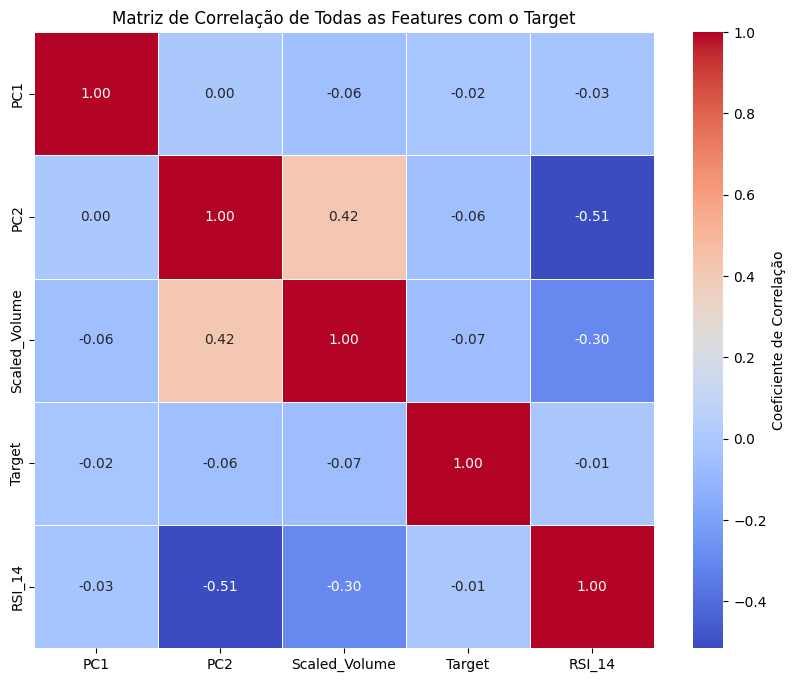

In [457]:


# 2. Calcular a matriz de correlação
correlation_matrix_pca = df_pypl_PCA.corr()

# 3. Mostrar a correlação das features APENAS com a coluna 'Target' (ordenada)
print("Correlação das Features com o Target (Lagged e Limpo):\n")
print(correlation_matrix.loc['Target'].sort_values(ascending=False))
print("-" * 50)

# 4. Visualização da matriz de correlação (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_pca,
    annot=True,          # Mostrar os valores de correlação
    cmap='coolwarm',     # Esquema de cores (coolwarm: quente para positivo, frio para negativo)
    fmt=".2f",           # Formato para 2 casas decimais
    linewidths=.5,       # Linhas entre as células
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('Matriz de Correlação de Todas as Features com o Target')

plt.show()

In [460]:
features_RSI = ["PC1", "PC2", "Scaled_Volume", "RSI_14"]
X_RSI = df_pypl_PCA [features_RSI]
y_RSI = df_pypl_PCA["Target"]
X_train_RSI, X_test_RSI, y_train_RSI, y_test_RSI = train_test_split( X_RSI, y, test_size=0.2, shuffle=False)
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled_RSI= scaler.fit_transform(X_train_RSI)
X_test_scaled_RSI = scaler.transform(X_test_RSI)

model_RSI = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42,class_weight='balanced')
model_RSI.fit(X_train_scaled_RSI, y_train_RSI)
y_pred_RSI = model_RSI.predict(X_test_scaled_RSI)
print(accuracy_score(y_test_SMA, y_pred_SMA))
cm_RSI= confusion_matrix(y_test_RSI, y_pred_RSI)
print(cm_RSI)
print(classification_report(y_test_RSI, y_pred_RSI, target_names=['DOWN (0)', 'UP (1)']))


0.5376569037656904
[[ 85 139]
 [ 90 164]]
              precision    recall  f1-score   support

    DOWN (0)       0.49      0.38      0.43       224
      UP (1)       0.54      0.65      0.59       254

    accuracy                           0.52       478
   macro avg       0.51      0.51      0.51       478
weighted avg       0.52      0.52      0.51       478



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




model_NN = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    activation='relu',            
    solver='adam',                
    max_iter=500,                 
    random_state=42,
    learning_rate_init=0.001
)

print("\n--- A Treinar o MLPClassifier (Rede Neural) ---")
model_NN.fit(X_train_RSI, y_train_RSI)



y_pred_NN = model_NN.predict(X_test_RSI)

print("\n--- Resultados FINAIS do MLPClassifier (PCA + Volume + GARCH Volatilidade) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_NN):.4f}")
print("Matriz de Confusão:")
cm_NN = confusion_matrix(y_test, y_pred_NN)
print(cm_NN)
print("\nRelatório de Classificação:")

print(classification_report(y_test, y_pred_NN, target_names=['DOWN (0)', 'UP (1)']))


--- A Treinar o MLPClassifier (Rede Neural) ---

--- Resultados FINAIS do MLPClassifier (PCA + Volume + GARCH Volatilidade) ---
Acurácia: 0.5084
Matriz de Confusão:
[[ 63 161]
 [ 74 180]]

Relatório de Classificação:
              precision    recall  f1-score   support

    DOWN (0)       0.46      0.28      0.35       224
      UP (1)       0.53      0.71      0.61       254

    accuracy                           0.51       478
   macro avg       0.49      0.49      0.48       478
weighted avg       0.50      0.51      0.49       478



# Risk Management on PayPal Stocks

Risk Management is fundamental to predict the behavior of stocks. Markowitz stated in his famous book, that volatility, which was a phenomenon not closely linked to math, to be the standard deviation of returns, $\sigma_r$.

There are Several methods to predict volatility, we will start with 2 classical ones and then move to a machine learning approach, with support vector regressors and neural networks. 

But first we will calculate the return volatility by using the formula for the Realized Volatility:

$$ \sigma=\sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n -\mu_r)^2} $$

where $N$ is the number of observations, $r_n$ is the return at observation $n$ and $\mu_r$ is the average return

In [406]:
ret = 100 * (df_pypl['close'].pct_change()).dropna()
realized_vol = ret.rolling(5).std()

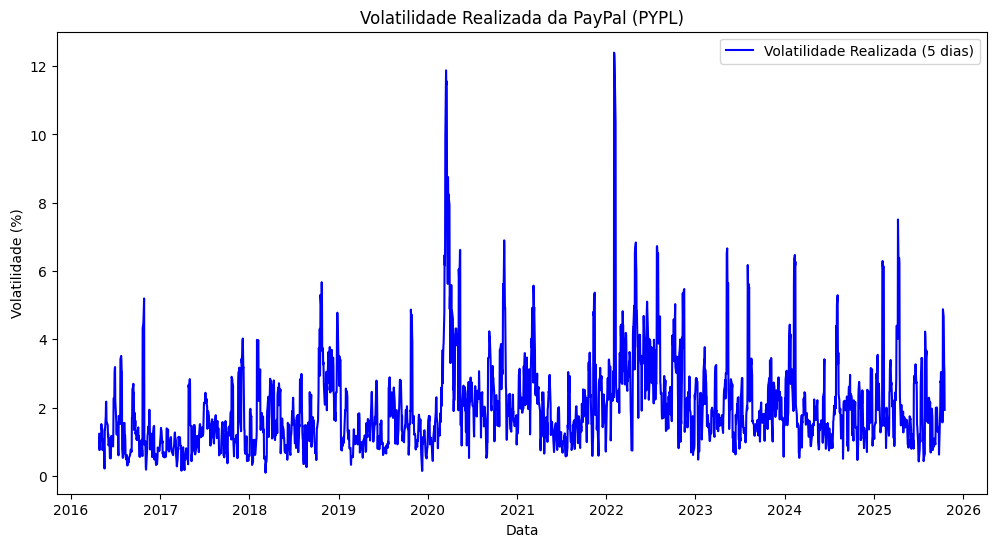

In [407]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label='Volatilidade Realizada (5 dias)', color='blue')
plt.title('Volatilidade Realizada da PayPal (PYPL)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.legend()
plt.show()

This is interesting because we can see big spikes on 2020 and 2022:

- 2020: Begining of the COVID pandemic

- 2022: A shocking report about the Q4 2021 was released. The sharp drop was due to the company drastically cutting its growth forecasts.

In [408]:
retv = ret.values

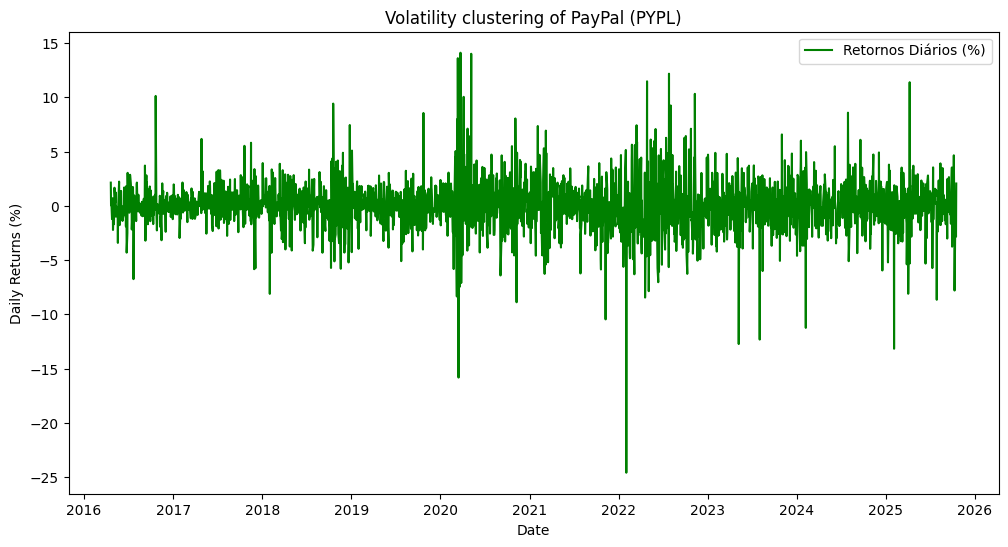

In [409]:
plt.figure(figsize=(12, 6))
plt.plot(df_pypl.index[1:], retv, label='Retornos Diários (%)', color='green')
plt.title('Volatility clustering of PayPal (PYPL)')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.show()

with this volatility clustering we can now in which direction was the spikes on 2020 and 2022 (downwards)

## ARCH Model

The ARCH model was one of the first statistical models introduced to predict volatility: the ARCH model is a univariate model and based on historical asset returns

$$\sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t - k})^2$$

where the mean model is:

$$ r_t = \sigma_t \epsilon_t $$

where $\epsilon_t$ is assumed to be normally distributed

In this project we will not implement the ARCH model from the ground, instead we will use the arch library

In [410]:
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

In [411]:
arch = arch_model(ret, mean="Zero", vol="ARCH", p=1).fit(disp="off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5445.56
Distribution:                  Normal   AIC:                           10895.1
Method:            Maximum Likelihood   BIC:                           10906.7
                                        No. Observations:                 2389
Date:                Mon, Nov 17 2025   Df Residuals:                     2389
Time:                        21:15:07   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.7038      0.355     13.264  3.754e-40   [  4.00

In [448]:
n=255
split_date=ret.iloc[-n:].index


In [413]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())

forecast_arch = arch.forecast(start=split_date[0])


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5329.29
Distribution:                  Normal   AIC:                           10668.6
Method:            Maximum Likelihood   BIC:                           10697.5
                                        No. Observations:                 2389
Date:                Mon, Nov 17 2025   Df Residuals:                     2389
Time:                        21:15:07   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.6979      0.333      8.091  5.925e-16    [  

In [ ]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
model = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42, class_weight='balanced')

In [ ]:
model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.5328185328185329


In [ ]:
cm= confusion_matrix(y_test, y_pred)
print(cm)

[[138 104]
 [138 138]]


In [ ]:
print(classification_report(y_test, y_pred, target_names=['DOWN (0)', 'UP (1)']))

              precision    recall  f1-score   support

    DOWN (0)       0.50      0.57      0.53       242
      UP (1)       0.57      0.50      0.53       276

    accuracy                           0.53       518
   macro avg       0.54      0.54      0.53       518
weighted avg       0.54      0.53      0.53       518



As we can see, using only the features provided by the dataset, we got a result of 53%, which is a slight improvement to choosing randomly. But for some strange reason, the model can predict more UPs then DOWNs

In [414]:
rmse_arch=np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_arch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for ARCH model: {rmse_arch}")

RMSE for ARCH model: 0.22016866484574288


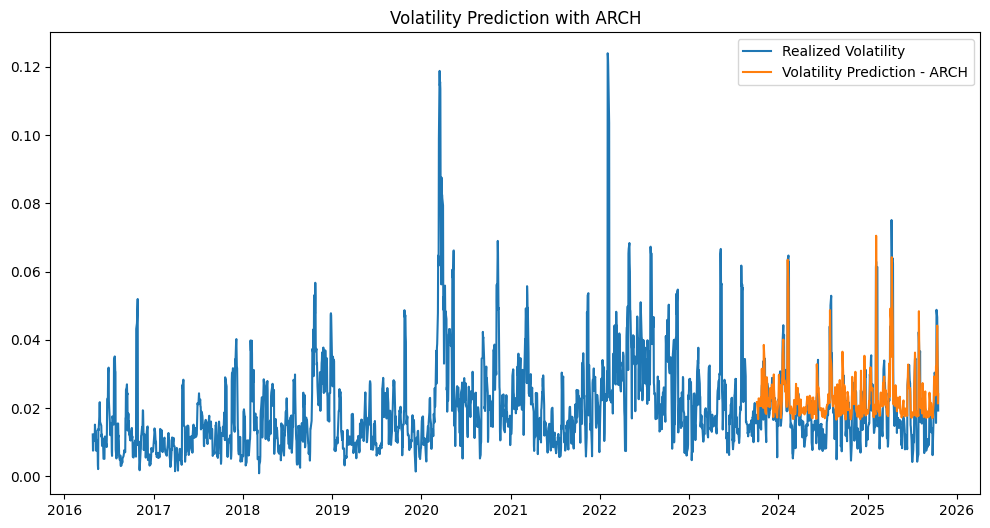

In [415]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_arch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - ARCH")
plt.title("Volatility Prediction with ARCH", fontsize = 12)
plt.legend()
plt.show()

As we can see we got a nice prediction of the volatility, even using an old model such as ARCH.

Disadvantages of using ARCH:
- Needs a lot of parameters: Markets are complex, and ARCH model can not capture all the shocks of volatility in data using a small $p$. To get a good modelation, a higher $p$ would be necessary

- Non-negativity: Two of the assumptions of ARCH are that $\alpha_k$ and $\omega$ are $>0$ which turns the volatility hard to model.

- Information assimetry: ARCH only looks for past returns, $r_{t-k} ^2$ to predict future volatility, $\sigma_t ^2$, but ignores the direction of the shock. This means that the model cannot capture the leverage effect: Bad news tend to a higher volatility and good news tends to lower volatility.

## GARCH model

GARCH is an extension of ARCH incorporating lagged conditional variance. This makes the model multivariate in the sense that it is an autoregressive moving average model.

In [416]:
bic_garc= []

for p in range (1,5):
    for q in range(1,5):
        garch = arch_model(ret, mean="zero", vol="GARCH", p=p, o=0, q=q).fit(disp="off")
        bic_garc.append(garch.bic)
        if garch.bic == np.min(bic_garc):
            best_param = (p,q)
garch = arch_model(ret, mean="zero", vol="GARCH", p=best_param[0], o=0, q=best_param[1]).fit(disp="off")
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
forecast_garch 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5282.59
Distribution:                  Normal   AIC:                           10575.2
Method:            Maximum Likelihood   BIC:                           10604.1
                                        No. Observations:                 2389
Date:                Mon, Nov 17 2025   Df Residuals:                     2389
Time:                        21:15:08   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3677      0.157      2.335  1.955e-02 [5.904e-0

In [417]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_garch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for GARCH model: {rmse_garch}")

RMSE for GARCH model: 0.2140608373982105


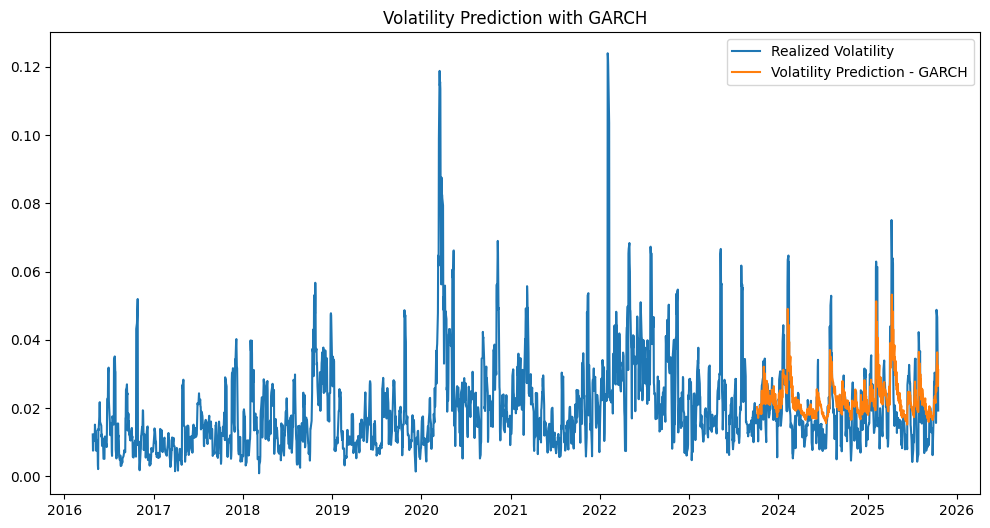

In [418]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_garch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - GARCH")
plt.title("Volatility Prediction with GARCH", fontsize = 12)
plt.legend()
plt.show()

We can see that GARCH got a slight better value than ARCH, but still a bad value.

## Support Vector Regression with GARCH

We can use machine learning to get the optimized parameters, 

In [419]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [420]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)


In [421]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [422]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [423]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop("index", axis=1, inplace=True)

In [424]:
svr_poly=SVR(kernel="poly", degree=2)
svr_lin=SVR(kernel="linear")
svr_rbf=SVR(kernel="rbf")

In [425]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf_lin = RandomizedSearchCV(svr_lin, para_grid, n_jobs=-1)
clf_lin.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf_lin.predict(X.iloc[-n:])

In [426]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [427]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print(f"RMSE for SVR model: {rmse_svr}")

RMSE for SVR model: 0.0011131121007058715


In [428]:
realized_vol.index=ret.iloc[4:].index

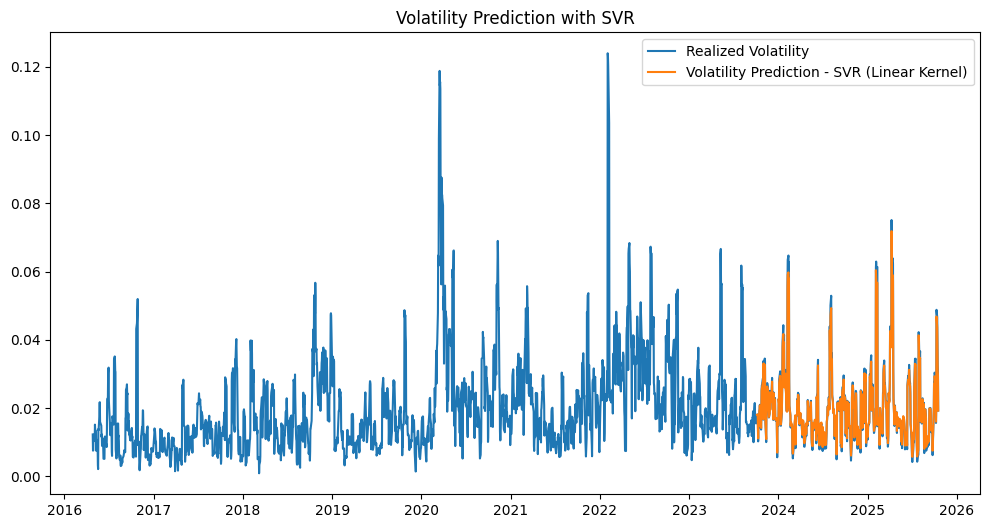

In [429]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_lin / 100, label="Volatility Prediction - SVR (Linear Kernel)")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

In [430]:
clf_rbf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs=-1)
clf_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf_rbf.predict(X.iloc[-n:])

In [431]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [432]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is 0.002924


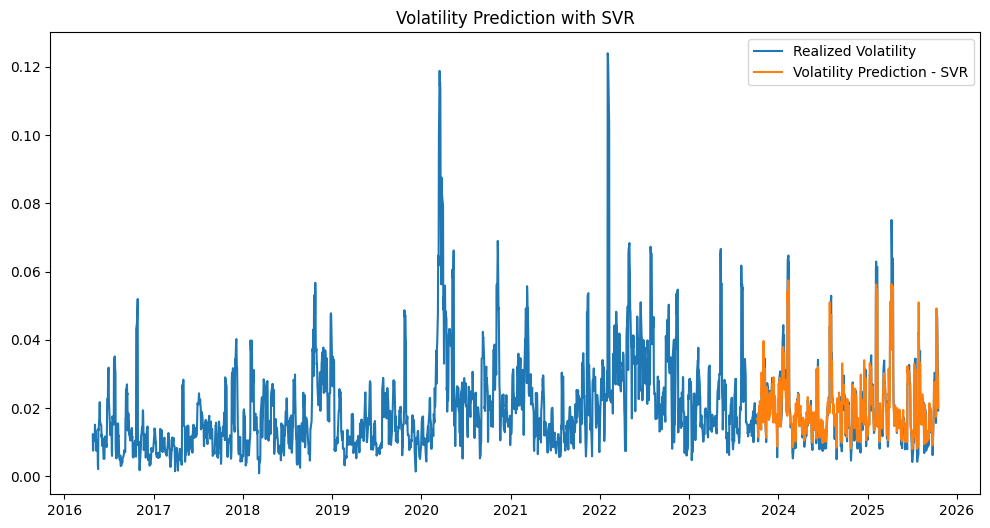

In [433]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_rbf / 100, label="Volatility Prediction - SVR")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

## Neural Networks on GARCH

In [434]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],'max_iter': [500, 1000],'alpha': [0.00005, 0.0005 ]}
clf_NN = RandomizedSearchCV(NN_vol, para_grid_NN)
clf_NN.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf_NN.predict(X.iloc[-n:])

In [435]:
NN_predictions= pd.DataFrame(NN_predictions)
NN_predictions.index=ret.iloc[-n:].index

In [436]:
rmse_svr_nn = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of Neural Network is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of Neural Network is 0.002924


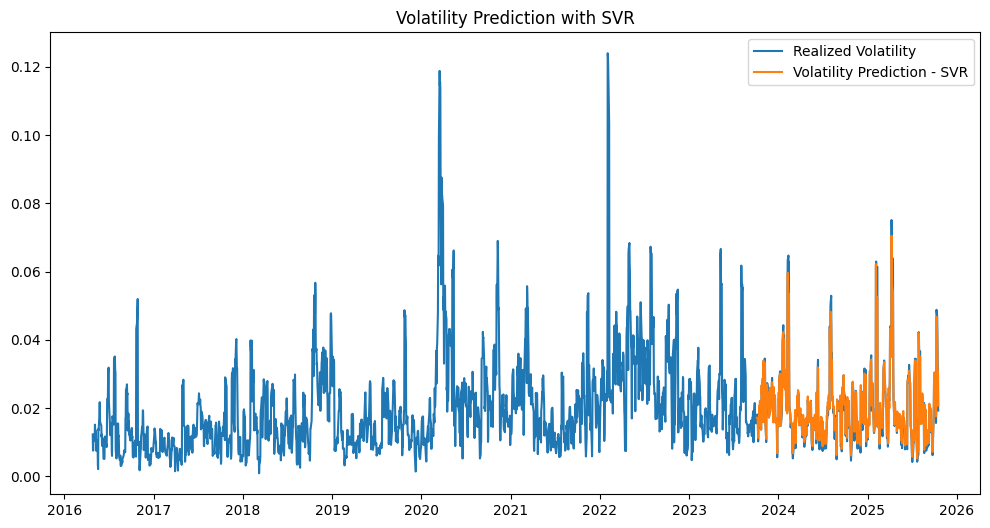

In [437]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(NN_predictions / 100, label="Volatility Prediction - SVR")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

## Deep Learning on GARCH

In [438]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

In [439]:
model = keras.Sequential([layers.Dense(256, activation="relu"), layers.Dense(128, activation="relu"), layers.Dense(1, activation="linear")])

In [440]:
model.compile(loss="mse", optimizer="rmsprop")

In [441]:
epochs_trial= np.arange(100,400,4)
batch_trial= np.arange(100,400, 4)
DL_pred=[]
DL_RMSE=[]
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,), batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] /100, DL_predict.flatten() /100)))
    DL_pred.append(DL_predict)
    print("DL_RMSE_{}:{:.6f}".format(i+1, DL_RMSE[i]))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_1:0.001858
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
DL_RMSE_2:0.001907
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
DL_RMSE_3:0.002079
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
DL_RMSE_4:0.002247


In [442]:
DL_predict= pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index= ret.iloc[-n:].index

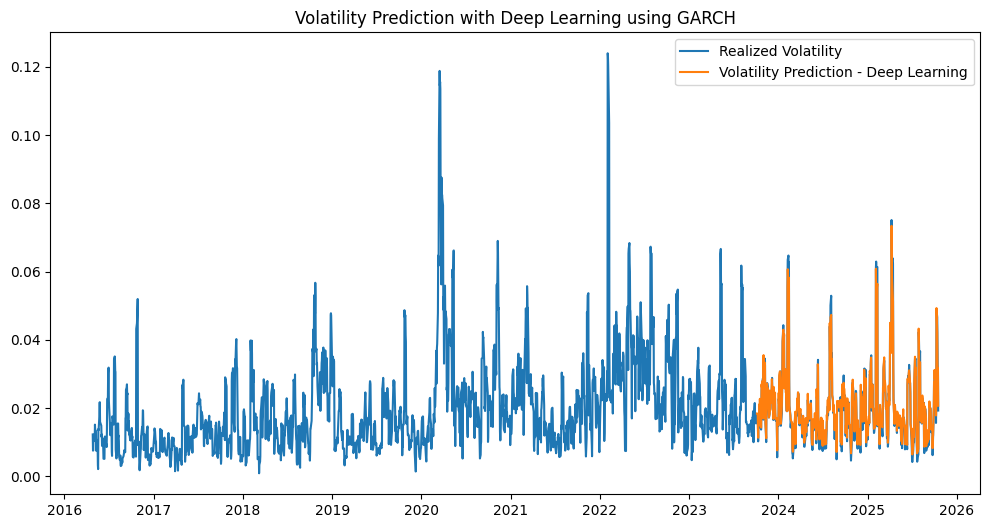

In [443]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(DL_predict / 100, label="Volatility Prediction - Deep Learning")
plt.title("Volatility Prediction with Deep Learning using GARCH", fontsize=12)
plt.legend()
plt.show()

As far as we tested, based on RMSE, a SVR using a linear kernel function was the best method to predict risk on PayPal stocks. This will be a useful feature to implement to predict stock direction.

# Predicting stock direction with LINEAR SVR GARCH  